# Exercise 5.2 - Finding dogs among cupcakes

This is an extension of exercise 5.1
Here we show how to build a basic neural network for identifying dog or muffin. This time we will focus more on the CNN models and see how they can be improved to perform better than the randoms as we saw before.

In [1]:
%matplotlib inline
import os
from IPython.display import display
import numpy as np  # linear algebra / matrices
from skimage.color import label2rgb
from sklearn.metrics import roc_curve, auc  # roc curve tools
from skimage.segmentation import mark_boundaries  # mark labels
from skimage.io import imread  # read in images
import matplotlib.pyplot as plt  # plotting

In [2]:
base_path = '../04-Segmentation/04-files'
seg_path = os.path.join(base_path, 'DogVsMuffin_seg_bw.jpg')
rgb_path = os.path.join(base_path, 'DogVsMuffin.jpg')
face_path = os.path.join(base_path, 'DogVsMuffin_face.jpg')
seg_img = imread(seg_path)[80:520:2, :450:2]
rgb_img = imread(rgb_path)[80:520:2, :450:2, :]
face_img = imread(face_path)
print('RGB Size', rgb_img.shape, 'Seg Size',
      seg_img.shape, 'Face Size', face_img.shape)

RGB Size (220, 225, 3) Seg Size (220, 225) Face Size (111, 131, 3)


# Calculate the baseline ROC curve

In [3]:
ground_truth_labels = seg_img.flatten() > 0
score_value = 1-np.mean(rgb_img.astype(np.float32), 2).flatten()/255.0
fpr, tpr, _ = roc_curve(ground_truth_labels, score_value)
roc_auc = auc(fpr, tpr)

Text(0.5, 1.0, 'Labeled Image')

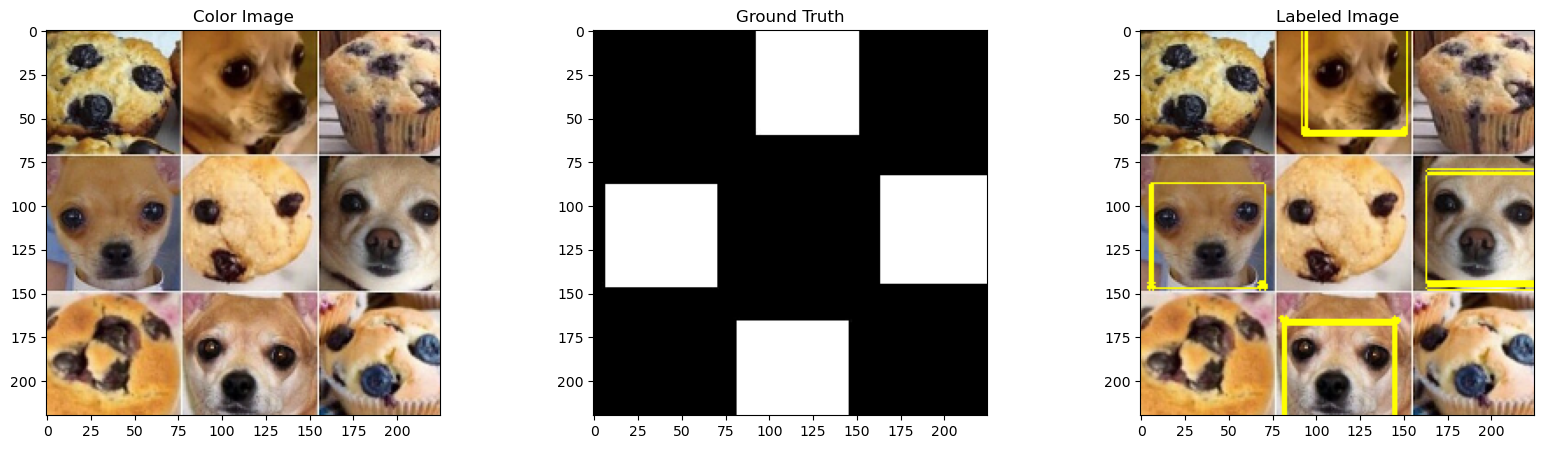

In [4]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, cmap='gray')  # show the segments
ax2.set_title("Ground Truth")
ax3.imshow(mark_boundaries(rgb_img, seg_img))
ax3.set_title("Labeled Image")

# Build the Model
We use a library called [Keras](https://keras.io/) which lets us easily build models and avoid making easy mistakes. We focus here on just a single convolutional layers with dimensions 25x25.

### Data Preparation
We need to redimnsion the arrays to use them in deep learning libraries. Keras and Tensorflow use the forman BHWC (Batch, Height, Width, Channels) since we just have a single item in our batch we can use `np.expand_dims` to add that dimension.

In [5]:
img_tensor = np.expand_dims(rgb_img, 0)/255.0
seg_tensor = np.expand_dims(np.expand_dims(seg_img/255.0, -1), 0)

In [6]:
kernel_dim = 25
np.random.seed(2019)
from functools import reduce
def gkern_nd(d=2, kernlen=21, nsigs=3, min_smooth_val=1e-2):
    nsigs = [nsigs] * d
    k_wid = (kernlen - 1) / 2
    all_axs = [np.linspace(-k_wid, k_wid, kernlen)] * d
    all_xxs = np.meshgrid(*all_axs)
    all_dist = reduce(np.add, [
        np.square(cur_xx) / (2 * np.square(np.clip(nsig, min_smooth_val,
                                                   kernlen)))
        for cur_xx, nsig in zip(all_xxs, nsigs)])
    kernel_raw = np.exp(-all_dist)
    return kernel_raw / kernel_raw.sum()

init_W = np.random.normal(0, 0.005, size=(kernel_dim, kernel_dim, 3, 1))
for i in range(np.shape(init_W)[2]):
    init_W[:, :, i, 0] += gkern_nd(2, kernel_dim)

Text(0.5, 1.0, 'Blue Kernel')

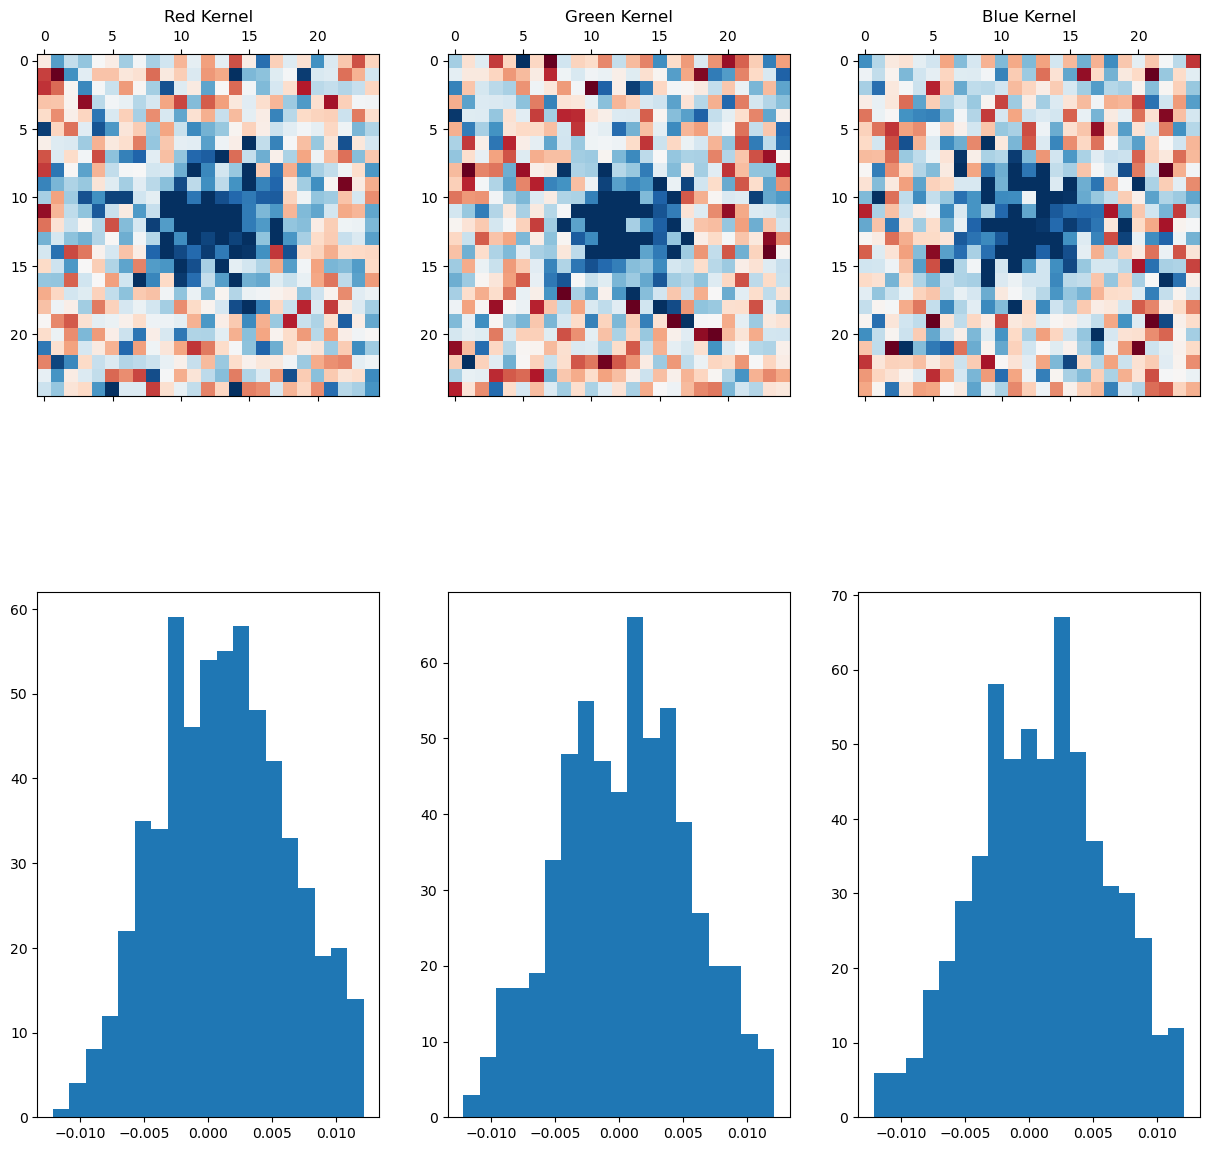

In [7]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 15))
plt_kwargs = dict(cmap='RdBu', vmin=-init_W.std()*2, vmax=+init_W.std()*2)
bins = np.linspace(plt_kwargs['vmin'], plt_kwargs['vmax'], 20)
ax1.matshow(init_W[:, :, 0, 0], **plt_kwargs)
ax4.hist(init_W[:, :, 0, 0].ravel(), bins)
ax1.set_title('Red Kernel')

ax2.matshow(init_W[:, :, 1, 0], **plt_kwargs)
ax5.hist(init_W[:, :, 1, 0].ravel(), bins)
ax2.set_title('Green Kernel')

ax3.matshow(init_W[:, :, 2, 0], **plt_kwargs)
ax6.hist(init_W[:, :, 2, 0].ravel(), bins)
ax3.set_title('Blue Kernel')

In [8]:
from keras import models, layers, optimizers
from keras.optimizers import adam_v2
from keras.optimizers import sgd_experimental
simple_model = models.Sequential(name='SingleConvLayer')
# learn one convolution layer
simple_model.add(layers.Conv2D(1, 
                               kernel_size=(kernel_dim, kernel_dim),
                               input_shape = (None, None, 3),
                               use_bias=False,
                               weights=[init_W],
                               activation='sigmoid',
                               padding='same'))
# the optimizer (how the model is updated)
# loss (what is are we trying to minimize)
# metrics (how we measure the performance)
simple_model.compile(optimizer=sgd_experimental.SGD(learning_rate=1e-2),
                     loss='binary_crossentropy',
                     metrics=['binary_accuracy', 'mse'])
simple_model.summary()

2024-03-21 11:12:39.046817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 11:12:47.103229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 11:12:47.588489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 11:12:47.588559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/000

Model: "SingleConvLayer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 1)     1875      
                                                                 
Total params: 1,875
Trainable params: 1,875
Non-trainable params: 0
_________________________________________________________________


In [9]:
simple_model.fit(img_tensor,
                 seg_tensor,
                 epochs=1)

2024-03-21 11:12:57.178113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-03-21 11:13:03.603904: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6572742800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 11:13:03.603940: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A1000 Laptop GPU, Compute Capability 8.6
2024-03-21 11:13:03.838640: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 13s 13s/step - loss: 1.3026 - binary_accuracy: 0.2844 - mse: 0.4841


1/1 [==============================] - 0s 111ms/step


Text(0.5, 1.0, 'CNN Prediction')

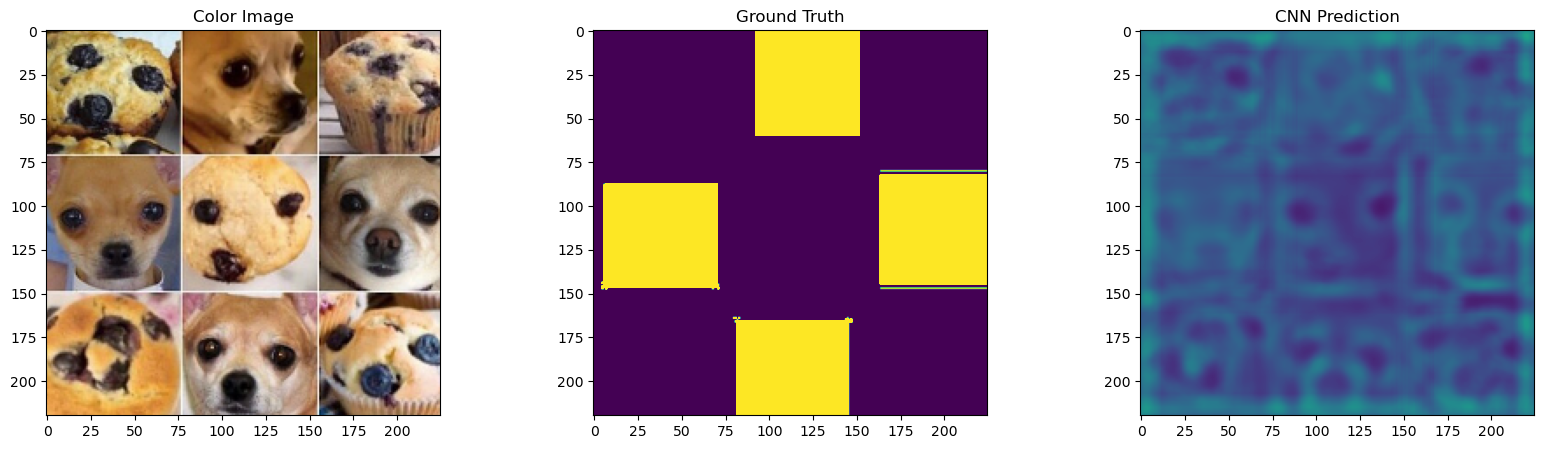

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin=0, vmax=1, cmap='viridis')  # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(img_tensor)
ax3.imshow(m_output[0, :, :, 0], vmin=0, vmax=1, cmap='viridis')
ax3.set_title("CNN Prediction")

In [11]:
loss_history = simple_model.fit(img_tensor,
                                seg_tensor,
                                epochs=10,
                                verbose=False)
print('Pixel Level Accuracy: {:2.1%}'.format(
    loss_history.history['binary_accuracy'][-1]
))

Pixel Level Accuracy: 70.1%


1/1 [==============================] - 0s 61ms/step


Text(0.5, 1.0, 'CNN Prediction')

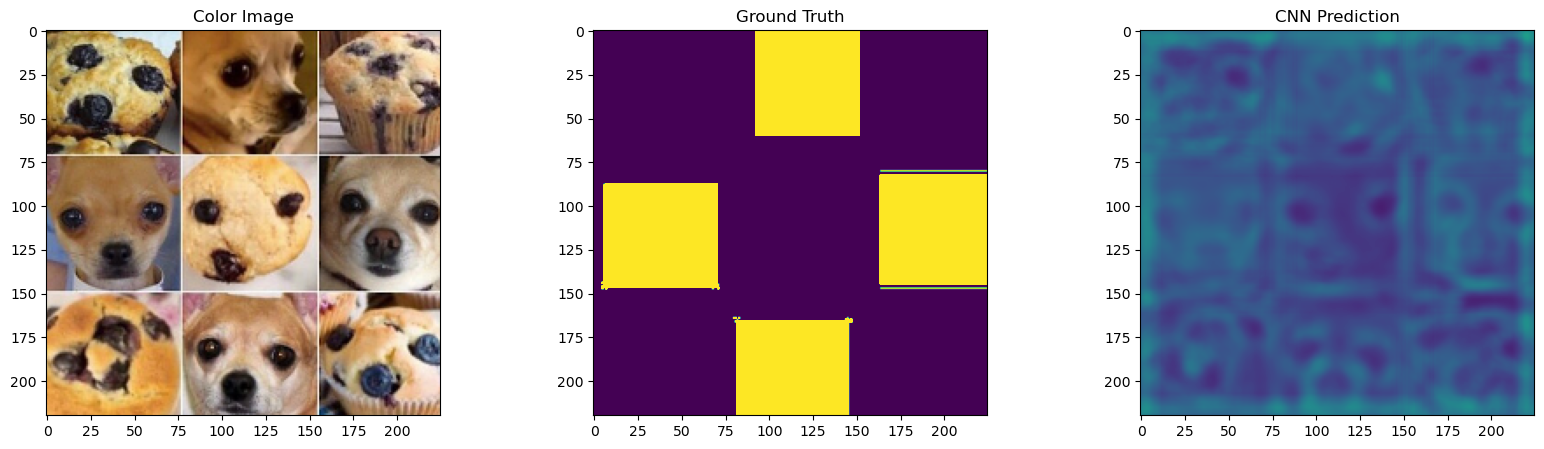

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin=0, vmax=1, cmap='viridis')  # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(img_tensor)
ax3.imshow(m_output[0, :, :, 0], vmin=0, vmax=1, cmap='viridis')
ax3.set_title("CNN Prediction")

In [13]:
fpr_cnn, tpr_cnn, _ = roc_curve(ground_truth_labels, m_output.ravel())
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

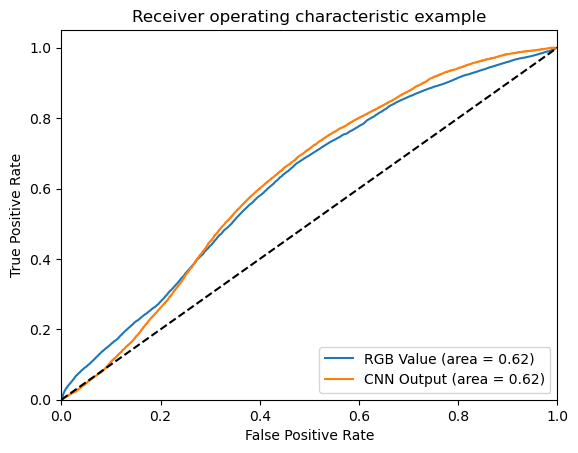

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label='RGB Value (area = %0.2f)' % roc_auc)
ax.plot(fpr_cnn, tpr_cnn, label='CNN Output (area = %0.2f)' % roc_auc_cnn)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## Augmentation
We use the augmentation methods covered in the Datasets lecture to increase the amount of data we have and make the model less sennsitive to small changes.

In [15]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(rotation_range=15,
                         zoom_range=0.25,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         vertical_flip=True,
                         horizontal_flip=True)
img_gen = idg.flow(img_tensor, seed=1234)
seg_gen = idg.flow(seg_tensor, seed=1234)

In [16]:
simple_model.fit_generator(zip(img_gen, seg_gen), 
                           steps_per_epoch=20, 
                           epochs=5)

/tmp/ipykernel_189442/667735764.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  simple_model.fit_generator(zip(img_gen, seg_gen),


Epoch 1/5
20/20 [==============================] - 3s 103ms/step - loss: 0.5906 - binary_accuracy: 0.6939 - mse: 0.1997
Epoch 2/5
20/20 [==============================] - 2s 123ms/step - loss: 0.5891 - binary_accuracy: 0.6908 - mse: 0.1989
Epoch 3/5
20/20 [==============================] - 2s 115ms/step - loss: 0.5778 - binary_accuracy: 0.6980 - mse: 0.1942
Epoch 4/5
20/20 [==============================] - 3s 144ms/step - loss: 0.5804 - binary_accuracy: 0.7006 - mse: 0.1952
Epoch 5/5
20/20 [==============================] - 3s 125ms/step - loss: 0.5839 - binary_accuracy: 0.6954 - mse: 0.1967


1/1 [==============================] - 0s 47ms/step


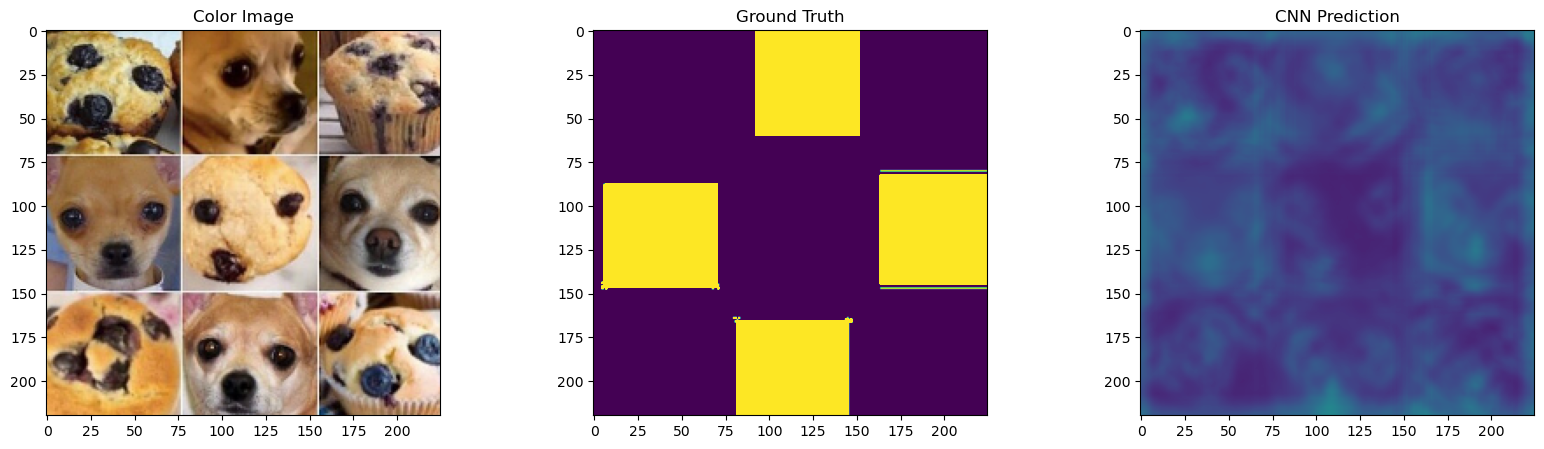

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin=0, vmax=1, cmap='viridis')  # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(img_tensor)
ax3.imshow(m_output[0, :, :, 0], vmin=0, vmax=1, cmap='viridis')
ax3.set_title("CNN Prediction");

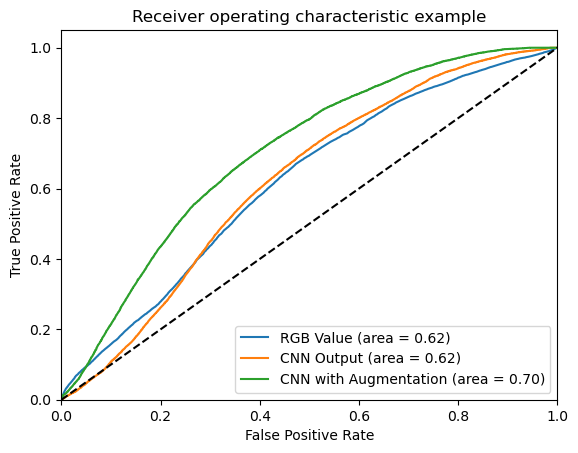

In [18]:
fpr_aug, tpr_aug, _ = roc_curve(ground_truth_labels, m_output.ravel())
roc_auc_aug = auc(fpr_aug, tpr_aug)

fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label='RGB Value (area = %0.2f)' % roc_auc)
ax.plot(fpr_cnn, tpr_cnn, label='CNN Output (area = %0.2f)' % roc_auc_cnn)
ax.plot(fpr_aug, tpr_aug, label='CNN with Augmentation (area = %0.2f)' % roc_auc_aug)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## What did the model learn?
We can look at the exact convolutions the model learned by using the `get_weights` on the layer we are interested in

In [19]:
W,  = simple_model.layers[0].get_weights()
print('Convolution:', W.shape, W.mean(), W.std())

Convolution: (25, 25, 3, 1) -0.0011015952 0.0058399606


Text(0.5, 1.0, 'Blue Kernel')

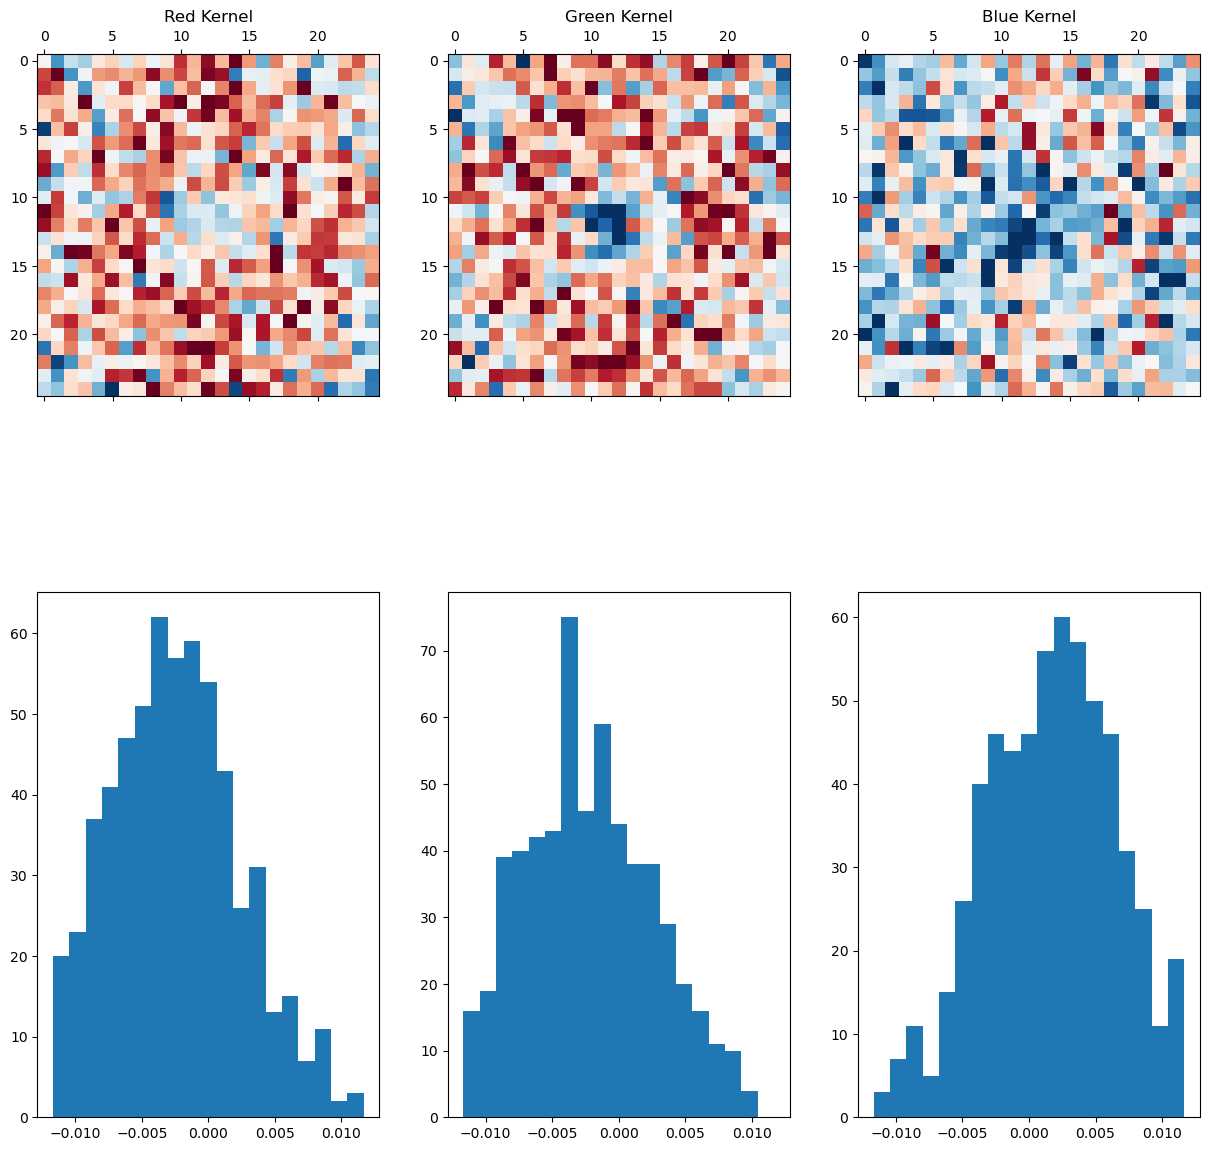

In [20]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 15))
plt_kwargs = dict(cmap='RdBu', vmin=-W.std()*2, vmax=+W.std()*2)
bins = np.linspace(plt_kwargs['vmin'], plt_kwargs['vmax'], 20)
ax1.matshow(W[:, :, 0, 0], **plt_kwargs)
ax4.hist(W[:, :, 0, 0].ravel(), bins)
ax1.set_title('Red Kernel')

ax2.matshow(W[:, :, 1, 0], **plt_kwargs)
ax5.hist(W[:, :, 1, 0].ravel(), bins)
ax2.set_title('Green Kernel')

ax3.matshow(W[:, :, 2, 0], **plt_kwargs)
ax6.hist(W[:, :, 2, 0].ravel(), bins)
ax3.set_title('Blue Kernel')

### Tasks
1. How can you improve the neural network model (what can you add, or change)?
2. Where might morphological operations fit in?
3. What is wrong with our approach for validating the model here? (what data are we using to measure the accuracy)
4. What is the loss and how is it being used?

